In [1]:
# get data
import numpy as np
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [8]:
fs_peptide.data_dir

'C:\\Users\\minch_000\\msmbuilder_data\\fs_peptide'

In [3]:
# Open trajectories

from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X)

C:\Users\minch_000\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length set([500.0]) ns


In [4]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(1000L, 264L, 3L)
(1000L, 84L)


In [5]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000L, 84L)
(1000L, 4L)


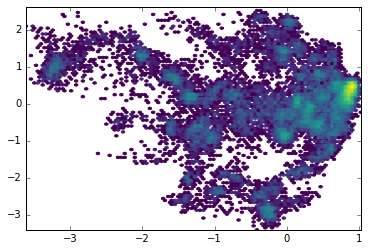

In [6]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [7]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans

clusterer = MiniBatchKMeans(n_clusters=97)
clustered_trajs = tica_trajs.fit_transform_with(clusterer, 'kmeans/', fmt='dir-npy')

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000L, 4L)
(1000L,)


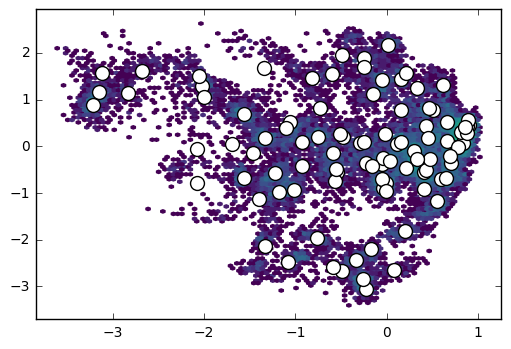

In [8]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [8]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20, ergodic_cutoff='on')
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

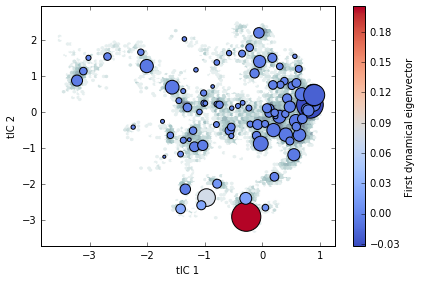

In [9]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [10]:
from msmbuilder.tpt import mfpts 
mfpt_matrix = mfpts(msm)

In [21]:
np.savetxt('C:\Users\minch_000\Documents\TJ_data\\fspeptide\msm_out\cluster_assignments.csv', np.concatenate(clustered_trajs), delimiter=',')
np.savetxt('C:\Users\minch_000\Documents\TJ_data\\fspeptide\msm_out\\raw_XYZ_28000.csv', X, delimiter=',')
import msmbuilder.utils as msmutils
msmutils.dump(msm, 'C:\Users\minch_000\Documents\TJ_data\\fspeptide\msm_out\msm.pkl')


In [12]:
idx = np.argmax(msm.populations_)
max_pop = msm.populations_[idx]
print idx, max_pop

78 0.362598901243


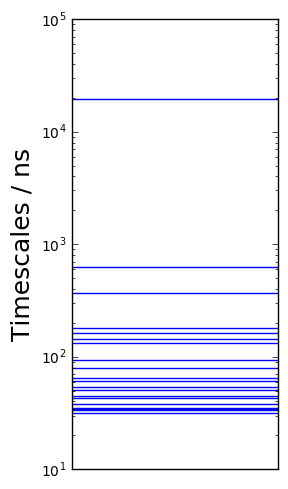

In [13]:

plt.subplots(figsize=(3,5))
plt.hlines(msm.timescales_ * to_ns, 0, 1, color='b')
plt.yscale('log')
plt.xticks([])
plt.ylabel("Timescales / ns", fontsize=18)
plt.tight_layout()

In [14]:
#macrostate model

from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.990240
         Iterations: 8
         Function evaluations: 68


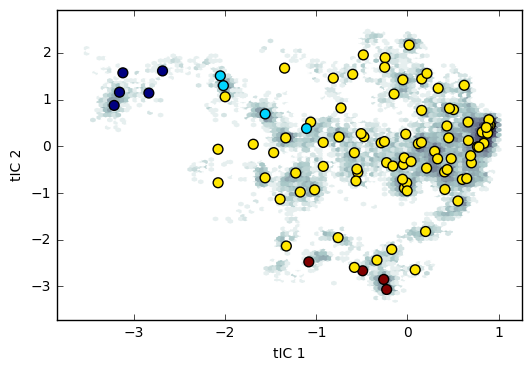

In [15]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')

In [16]:
# Get video of 1st Tica

# First organize data into rows
temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X) # Each row contains the raw data of the corresponding frame

In [17]:
import mdtraj as md

first_tICA = txx[:,0]
idx_sort = first_tICA.argsort()[-len(first_tICA):][::-1]
traj = idx_sort[::10]

tICA_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
md_traj = md.Trajectory(tICA_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
filename = 'first_tICA.xtc'
md_traj.save_xtc('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\\MSM_Builder_Test\\Eigen_Data\\' + filename)

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [18]:
#assigns every frame to a cluster

#Cluster locations: clusterer.cluster_centers_
#Frame locations: tica_trajs[0].shape

def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

msm_labels = msm.state_labels_

cluster_location = []
for traj in tica_trajs:
    for frame in traj:
        error = np.linalg.norm(clusterer.cluster_centers_ - frame, axis=1)
        idx = error.argsort()[:4]
        idx = intersect(idx, msm_labels)
        cluster_location.append(idx[0])

In [19]:
#Now we have the transition matrix and frame cluster location

#print msm.transmat_
#print cluster_location[1:1000]

In [20]:
import mdtraj as md
file_location = "C:\\Users\\Christian\\Documents\\GitHub\\Protein_Dynamics_TJ\\MSM_Builder_Test\\Data\\"
t = md.load(file_location + "aligned_xyz_reconst.dcd", top=file_location + "fs-peptide.pdb")

t2 = []
for idx, trajectories in enumerate(xyz):
    if idx == 0:
        t2 = trajectories
    if idx != 0:
        t2 = t2.join(trajectories)
        

# print t.xyz.shape
# print xyz[0].xyz.shape
temp = xyz[0]
reference_frame = temp.slice(0, copy=True)

#t1 contains the linear path
#t2 contains all the frames
t.superpose(reference_frame)
t2.superpose(reference_frame)

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Trajectory with 28000 frames, 264 atoms, 23 residues, without unitcells at 0x2e558828>

In [21]:
true_frame_order = []
i = 0
for frame in t:
    rmsds = md.rmsd(t2, frame)
    true_frame_order.append(rmsds.argmin())
print true_frame_order

[550, 410, 490, 500, 450, 470, 430, 420, 360, 460, 370, 16290, 16300, 16320, 16310, 16230, 16260, 16180, 16240, 16170, 16200, 20860, 20950, 24600, 24510, 24550, 24620, 24530, 24480, 24520, 24660, 24680, 24720, 24750, 24800, 24790, 19750, 19060, 19600, 19240, 19200, 19330, 19530, 19540, 19070, 19490, 19100, 26590, 26620, 17210, 26810, 11160, 26860, 11200, 17190, 26520, 10050, 10080, 10040, 10140, 10270, 7730, 7770, 7670, 7750, 3560, 20980, 14200, 13130, 23520, 23160, 20650, 11830, 3380, 14560, 1700, 23290, 24440, 23440, 9280, 9270, 25760, 8540, 20100, 20340, 17680, 1740, 20350, 9840, 8570, 20230, 9880, 8560, 25530, 20170, 20190, 9870, 25490, 20120, 1750, 20290, 20020, 25810, 8580, 17380, 9520, 8400, 9430, 9630, 9790, 9960, 9970, 25480, 25890, 25570, 9440, 8450, 9450, 9560, 24890, 9500, 9800, 8350, 25620, 24960, 8200, 13790, 24250, 24090, 24040, 24020, 24010, 8020, 8010, 24140, 24220, 21850, 21860, 21970, 21620, 21960, 21830, 21930, 21920, 21870, 21630, 9740, 5370, 5070, 5270, 5490, 5230

In [22]:
#true_frame_order
#cluster_location

markov_traj = []
for num in true_frame_order:
    markov_traj.append(cluster_location[num])

print markov_traj

[59, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 73, 35, 35, 35, 73, 73, 73, 73, 73, 73, 74, 74, 57, 74, 74, 47, 74, 74, 47, 9, 9, 32, 32, 32, 32, 36, 89, 2, 50, 50, 50, 2, 2, 2, 2, 2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 34, 34, 34, 34, 0, 23, 23, 74, 23, 74, 23, 23, 74, 23, 74, 23, 23, 74, 74, 83, 74, 74, 23, 33, 23, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 32, 9, 9, 9, 9, 33, 32, 32, 32, 32, 9, 32, 32, 32, 9, 32, 32, 32, 9, 9, 32, 32, 9, 32, 32, 10, 32, 34, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]


In [23]:
#check if reasonable result

for idx in range(0, len(markov_traj) - 1):
    first = idx
    second = idx + 1
    #print msm.transmat_[markov_traj[first], markov_traj[second]]

print lv.shape
print fs_peptide.data_dir
print np.argmax(np.array(msm.populations_))

NameError: name 'lv' is not defined

In [ ]:
v = msm.eigenvalues_
lv = msm.left_eigenvectors_
idx_sort = msm.populations_.argsort()[-len(msm.populations_):][::-1]
lv = lv[idx_sort,:]
v.dump('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\v_fs_original_stride_10.dat')
lv.dump('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\lv_fs_original_stride_10.dat')

In [ ]:
lv = msm.left_eigenvectors_
idx_sort = msm.populations_.argsort()[-len(msm.populations_):][::-1]
lv = lv[idx_sort,:]

lv_og = np.load('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\lv_fs_original_stride_10.dat')
print np.dot(lv_og[:,0], lv[:,0])/(np.linalg.norm(lv_og[:,0])*np.linalg.norm(lv[:,0]))

In [ ]:
#Plotting dot product of eigenvectors

import numpy as np
import scipy.linalg as linalg


cutoff = 0.01
y = []
x = range(1,21)
for n in x:
    transmat_cut = np.zeros(msm.transmat_.shape)
    for i in range(msm.transmat_.shape[0]):
        v = msm.transmat_[i,:]
        temp = np.zeros(v.shape)
        #idx = np.where(v > cutoff)[0]
        idx = v.argsort()[-n:][::-1]
        for j in idx:
            temp[j] = v[j]
        transmat_cut[i,:] = temp
    for i in range(msm.transmat_.shape[0]):
        transmat_cut[i,:] = transmat_cut[i,:]/sum(transmat_cut[i,:])

    w, lv, rv = linalg.eig(transmat_cut, left=True)
    idx = w.argsort()[::-1]
    w = w[idx]
    lv = lv[:,idx]
    rv = rv[:,idx]

    result = []
    for i in range(len(msm.eigenvalues_)):
        a = lv[:,i]
        b = msm.left_eigenvectors_[:,i]
        result.append(abs(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))
    print n, result[0:2]
    y.append(result)
y = np.array(y)
import matplotlib.pyplot as plt
plt.plot(x,y[:,0], label='stationary')
plt.plot(x,y[:,1], label='1st dynamical')
plt.plot(x,y[:,2], label='2nd dynamical')
plt.legend(loc='lower right')
plt.ylabel('some numbers')
plt.show()